# Genomic BPE Tests

In [ ]:
from pathlib import Path
import collections

from Bio import SeqIO
from fastai.text import *

import sentencepiece as spm

In [ ]:
max_sentence_len=20480 #arbitrary number chosen. Original true "max sentence length" would be 44674217

In [ ]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes')
path_to_files = path / 'genome_fastas'

In [ ]:
for i, file in enumerate(path_to_files.iterdir()):
    genome = SeqIO.parse(file, 'fasta')
    chroms = [GB for GB in genome if 'chromosome' in GB.description] #  remove plasmid
    genome = ''.join([i.seq.__str__() for i in chroms]).upper()
    genome += '\n'
    with open('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer/all_files.txt', 'a') as f:
        ind = 0
        while ind < len(genome):
            f.write(genome[ind:ind+max_sentence_len])
            f.write('\n')
            ind += max_sentence_len
    print('completed file {}/{}'.format(i,len(path_to_files.ls())))

In [ ]:
quotemark = '\"'
raw_text_path = '/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer/small_version_all_files.txt'
lang = 'dna'
pre_rules=None
post_rules=None
vocab_sz=None
max_vocab_sz=10000
model_type='bpe'
char_coverage=None
tmp_dir='tmp' 
enc='utf8'
coverage = 0.9998
spec_tokens = ['\u2581'+s for s in defaults.text_spec_tok]
spec_tokens.extend([str(i) for i in range(1, 21)])
cache_dir = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer')/tmp_dir

#changed line in fastai.text see: https://forums.fast.ai/t/multifit-runtime-error-permission-denied/72874/3
# in the end not creating model thru fastai. using sentencepiece package directly!
print(" ".join([
        f"--input={quotemark}{raw_text_path}{quotemark} --max_sentence_length={max_sentence_len}",
        f"--character_coverage={coverage}",
        f"--unk_id={len(defaults.text_spec_tok)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
        f"--user_defined_symbols={','.join(spec_tokens)}",
        f"--model_prefix={cache_dir/'spm'} --vocab_size={10000} --model_type={model_type}"]))

spm.SentencePieceTrainer.Train(" ".join([
        f"--input={quotemark}{raw_text_path}{quotemark} --max_sentence_length={max_sentence_len}",
        f"--character_coverage={coverage}",
        f"--unk_id={len(defaults.text_spec_tok)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
        f"--user_defined_symbols={','.join(spec_tokens)}",
        f"--model_prefix={cache_dir/'spm'} --vocab_size={10000} --model_type={model_type}"]))

In [ ]:
import sentencepiece as spm
s = spm.SentencePieceProcessor(model_file='/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer/tmp/spm.model')

In [ ]:
vocabs = [[s.id_to_piece(id), id] for id in range(s.get_piece_size())]

In [ ]:
import random
test_text = "".join([random.choice("ATCG") for _ in range(1000)])

print(test_text)
print(s.encode(test_text, out_type=str, enable_sampling=True, alpha=0.1)[0:10])
print(s.encode(test_text, out_type=int, enable_sampling=True, alpha=0.1)[0:10])

test_text_2 = "1 2 3 4"

print(test_text_2)
print(s.encode(test_text_2, out_type=str, enable_sampling=True, alpha=0.1)[0:10])
print(s.encode(test_text_2, out_type=int, enable_sampling=True, alpha=0.1)[0:10])


#  Trying out model

## Download Sentencepiece model

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Callable
import torch

# sets device for model and PyTorch tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7" # "-1" if want to run on a CPU, otherwise define the GPU number

print('number of devices: {}'.format(torch.cuda.device_count()))

os.environ["CUDA_VISIBLE_DEVICES"]="0"


number of devices: 8


In [2]:
from fastai import *
from fastai.text import ( BaseTokenizer, Tokenizer, Vocab, 
                         PreProcessor, ItemList, PathOrStr, 
                         DataFrame, Optional, Collection, 
                         IntsOrStrs, DataBunch, is_listy, 
                         ItemLists, TextList, SortishSampler, 
                         DataLoader, SortSampler, partial, 
                         pad_collate, TextLMDataBunch, data_collate, 
                         LanguageModelPreLoader, SPProcessor, PreProcessor )
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
#sys.path.append("../..")
from utils import ( _get_genomic_processor, get_model_clas, TextClasDataBunch, 
                    get_scores, split_data, GenomicTokenizer, get_model_LM, 
                   GenomicVocab, GenomicTextClasDataBunch, GenomicTextLMDataBunch)

In [4]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/')

In [5]:
df = pd.read_csv(path/'e_coli_lm_data.csv')

In [6]:
train_df, valid_df = split_data(df, 0.9)

In [ ]:
"""
from fastai.text import ListRules, ifnone, defaults
from fastai.text import ( BaseTokenizer, Tokenizer, Vocab, 
                         PreProcessor, ItemList, PathOrStr, 
                         DataFrame, Optional, Collection, 
                         IntsOrStrs, DataBunch, is_listy, 
                         ItemLists, TextList, SortishSampler, 
                         DataLoader, SortSampler, partial, 
                         pad_collate, TextLMDataBunch, data_collate, 
                         LanguageModelPreLoader, TextClasDataBunch, ifnone, 
                         is1d, AWD_LSTM, 
                         LinearDecoder, SequentialRNN, LanguageLearner, 
                         RNNLearner, awd_lstm_lm_split, MultiBatchEncoder, 
                         PoolingLinearClassifier, awd_lstm_clas_split, progress_bar )
from fastai.text.data import _join_texts, apply_rules, ProcessPoolExecutor, partition_by_cores

class GenomicSPProcessor(PreProcessor):
    "`PreProcessor` that tokenizes and numericalizes with `sentencepiece`"
    def __init__(self, ds:ItemList=None, pre_rules: ListRules=None, post_rules:ListRules=None, vocab_sz:int=None,
                 max_vocab_sz:int=30000, model_type:str='unigram', max_sentence_len:int=20480, lang='en',
                 char_coverage=None, tmp_dir='tmp', mark_fields:bool=False, include_bos:bool=True, 
                 include_eos:bool=False, sp_model=None, sp_vocab=None, n_cpus:int=None, enc='utf8'):
        try: from sentencepiece import SentencePieceTrainer,SentencePieceProcessor
        except ImportError:
            raise Exception('sentencepiece module is missing: run `pip install sentencepiece`')
        self.pre_rules,self.post_rules,self.enc = pre_rules,post_rules,enc
        self.mark_fields,self.include_bos,self.include_eos = mark_fields,include_bos,include_eos
        self.sp_model,self.sp_vocab,self.n_cpus = sp_model,sp_vocab,ifnone(n_cpus,defaults.cpus)
        self.train_func = None
        #partial(train_sentencepiece, pre_rules=pre_rules, post_rules=post_rules, vocab_sz=vocab_sz,
        #        max_vocab_sz=max_vocab_sz, model_type=model_type, max_sentence_len=max_sentence_len, lang=lang,
        #        char_coverage=char_coverage, tmp_dir=tmp_dir, enc=enc)

    def process_one(self, item, join=True):
        if join: text = _join_texts([item], self.mark_fields, self.include_bos, self.include_eos)[0]
        text = apply_rules(text, pre_rules=self.pre_rules, post_rules=self.post_rules)
        return self._encode_batch([text])[0]

    def process(self, ds):
        ds.items = _join_texts(ds.items, self.mark_fields, self.include_bos, self.include_eos)
        ds.items = [apply_rules(t, pre_rules=self.pre_rules, post_rules=self.post_rules) 
                    for t in progress_bar(ds.items, leave=False)]
        if self.sp_model is None or self.sp_vocab is None:
            cache_dir = self.train_func(ds.items, ds.path)
            self.sp_model,self.sp_vocab = cache_dir/'spm.model',cache_dir/'spm.vocab'
        if not getattr(self, 'vocab', False): 
            with open(self.sp_vocab, 'r', encoding=self.enc) as f: self.vocab = Vocab([line.split('\t')[0] for line in f.readlines()])
        if self.n_cpus <= 1: ds.items = self._encode_batch(ds.items)
        else:
            with ProcessPoolExecutor(self.n_cpus) as e:
                ds.items = np.array(sum(e.map(self._encode_batch, partition_by_cores(ds.items, self.n_cpus)), []))
        ds.vocab = self.vocab

    def _encode_batch(self, texts):
        from sentencepiece import SentencePieceProcessor
        tok = SentencePieceProcessor()
        tok.Load(str(self.sp_model))
        return [np.array(tok.encode_as_ids(texts))]
        #return [np.array(tok.EncodeAsIds(t)) for t in texts]
        

    @classmethod
    def load(cls, path:PathOrStr, tmp_dir:PathOrStr='tmp', name:str='spm'):
        cache_dir = Path(path)/tmp_dir
        return cls(sp_model=cache_dir/f'{name}.model', sp_vocab=cache_dir/f'{name}.vocab')

spm_dir = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer/tmp/')
gen_sp_processor =  GenomicSPProcessor(sp_model=spm_dir/'spm.model', 
                                       sp_vocab=spm_dir/'spm.vocab', 
                                       pre_rules=None, 
                                       post_rules=None, 
                                       vocab_sz=10000, 
                                       max_vocab_sz=10000, 
                                       model_type='bpe',
                                       max_sentence_len=20480, 
                                       lang='dna', 
                                       char_coverage=0.9998, 
                                       tmp_dir='tmp', 
                                       mark_fields=False, 
                                       include_bos=True, 
                                       include_eos=True,  
                                       enc='utf8')
"""

In [7]:
def remove_(text):
    return text.replace('_', '').strip()

def remove_from_list(texts):
    #print('texts are: {}'.format(texts))
    return [remove_single(text) for text in texts]

def remove_single(text):
    #print('applying ...')
    #text = text.replace('xxup ', '') # remove uppercase indicator (useless)
    text = text.upper() # make everything uppercase
    text = text.replace('XXBOS', 'xxbos') # undo uppercasing BOS
    text = text.replace('XXEOS', 'xxeos') # undo uppercasing EOS
    #text = text.replace('XXUP', 'xxup')
    #text = text.replace('XXREP', 'xxrep') # undo uppercasing REP
    return text

spm_dir = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer/tmp/')
gen_sp_processor = SPProcessor(sp_model=spm_dir/'spm.model', 
                               sp_vocab=spm_dir/'spm.vocab',
                               pre_rules=[remove_], 
                               post_rules=[remove_from_list], 
                               vocab_sz=10000, 
                               model_type='bpe',
                               max_sentence_len=20480, 
                               lang='dna', 
                               char_coverage=0.9998, 
                               tmp_dir='tmp', 
                               mark_fields=False, 
                               include_bos=True, 
                               include_eos=True,  
                               enc='utf8')

In [ ]:
"""
from fastai.text.data import _join_texts, apply_rules, ProcessPoolExecutor, partition_by_cores

def remove_(text):
    return text.replace('_', '').strip()

def remove_from_list(texts):
    print('texts are: {}'.format(texts))
    return [remove_single(text) for text in texts]

def remove_single(text):
    print('applying ...')
    #text = text.replace('xxup ', '') # remove uppercase indicator (useless)
    text = text.upper() # make everything uppercase
    text = text.replace('XXBOS', 'xxbos') # undo uppercasing BOS
    text = text.replace('XXEOS', 'xxeos') # undo uppercasing EOS
    #text = text.replace('XXUP', 'xxup')
    #text = text.replace('XXREP', 'xxrep') # undo uppercasing REP
    return text

#print(gen_sp_processor.process_one(train_df.iloc[0].Sequence[0:1000]))

join = True
item = train_df.iloc[0].Sequence[0:100]
gen_sp_processor.post_rules = [remove_from_list] #[lambda x: x.upper()]
gen_sp_processor.pre_rules = [remove_]

print(item)
if join: text = _join_texts([item], gen_sp_processor.mark_fields, gen_sp_processor.include_bos, gen_sp_processor.include_eos)[0]
#text = item
text = apply_rules(text, pre_rules=gen_sp_processor.pre_rules, post_rules=gen_sp_processor.post_rules)

encoding = gen_sp_processor._encode_batch([text])[0]
print('encoded: {}'.format(encoding))
#print('decoded: {}'.format(gen_sp_processor.vocab.textify(encoding)))

np.array(gen_sp_processor._encode_batch(['ACCT', 'CCAATCG']))
"""

In [8]:
class GenomicTextLMDataBunchSP(TextLMDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                processor:PreProcessor=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, bptt=70, collate_fn:Callable=data_collate, bs=64, **kwargs):
        "Create a `TextDataBunch` from DataFrames. `kwargs` are passed to the dataloader creation."
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() 
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        d1 = src.databunch(**kwargs)
        
        datasets = cls._init_ds(d1.train_ds, d1.valid_ds, d1.test_ds)            
        val_bs = bs
        datasets = [LanguageModelPreLoader(ds, shuffle=(i==0), bs=(bs if i==0 else val_bs), bptt=bptt, backwards=False) 
                    for i,ds in enumerate(datasets)]            
        dls = [DataLoader(d, b, shuffle=False) for d,b in zip(datasets, (bs,val_bs,val_bs,val_bs)) if d is not None]
        
        return cls(*dls, path=path, collate_fn=collate_fn, no_check=False)

data = GenomicTextLMDataBunchSP.from_df(path, train_df, valid_df, bs=428, processor=gen_sp_processor, text_cols=0, label_cols=1)

In [9]:
print('num tokens: {}'.format(len(data.vocab.itos)))
print('first sequence: {}'.format(train_df.iloc[0].Sequence))
print('encoded: {}'.format(data.train_ds[0]))
encoding = gen_sp_processor.process_one(train_df.iloc[0].Sequence)
print('decoded: {}'.format(gen_sp_processor.vocab.textify(encoding)))

num tokens: 10000
first sequence: AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCCGCCAAAATCACCAACCACCTGGTGGCGATGATTGAAAAAACCATTAGCGGCCAGGATGCTTTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTTGACGGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAAATAAAACATGTCCTGCATGGCATTAGTTTGTTGGGGCAGTGCCCGGATAGCATCAACGCTGCGCTGATTTGCCGTGGCGAGAAAATGTCGATCGCCATTATGGCCGGCGTATTAGAAGCGCGCGGTCACAACGTTACTGTTATCGATCCGGTCGAAAAACTGCTGGCAGTGGGGCATTACCTCGAATCTACCGTCGATATTGCTGAGTCCACCCGCCGTATTGCGGCAAGCCGCATTCCGGCTGATCACATGGTGCTGATGGCA
encoded: (Text [   2    9  188   50 ... 1597  369 9999    3], Emp

In [12]:
data.vocab.itos[35:55]

['GCC',
 'GGC',
 'TCC',
 'AT',
 'GGA',
 'AA',
 'ACC',
 'TT',
 'GTC',
 'GAC',
 'GGT',
 'AGC',
 'TGC',
 'ATC',
 'GGCC',
 'TTC',
 'GAA',
 'GAT',
 'GTT',
 'AAC']

## Train Model

In [13]:
np.save(path/'coli_vocab_sp.npy', data.vocab.itos)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.3

In [15]:
learn = get_model_LM(data, drop_mult, config)

In [16]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(10000, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10000, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10000, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


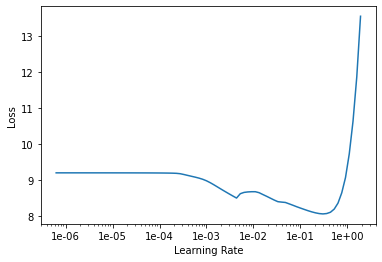

In [17]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('coli_only_LM_sp')

In [ ]:
learn.save_encoder('coli_only_LM_enc_sp')

##  Classification downstream task

In [ ]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/')
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [ ]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [ ]:
voc = np.load(path/'coli_vocab_sp.npy')
model_vocab = GenomicVocab(voc)

spm_dir = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/sentencepiece_tokenizer/tmp/')
gen_sp_processor = SPProcessor(sp_model=spm_dir/'spm.model', 
                               sp_vocab=spm_dir/'spm.vocab', 
                               pre_rules=None, 
                               post_rules=None, 
                               vocab_sz=10000, 
                               max_vocab_sz=10000, 
                               model_type='bpe',
                               max_sentence_len=20480, 
                               lang='dna', 
                               char_coverage=0.9998, 
                               tmp_dir='tmp', 
                               mark_fields=False, 
                               include_bos=True, 
                               include_eos=True,  
                               enc='utf8')

In [ ]:
class GenomicTextClasDataBunchSP(TextClasDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                processor:PreProcessor=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, pad_idx=1, pad_first=True, label_delim:str=None,
                bs=64, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames. `kwargs` are passed to the dataloader creation."
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_from_df(cols=label_cols, classes=classes, label_delim=label_delim)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        d1 = src.databunch(**kwargs)
        
        datasets = cls._init_ds(d1.train_ds, d1.valid_ds, d1.test_ds)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=False)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=bs, sampler=sampler, **kwargs))
            
        return cls(*dataloaders, path=path, collate_fn=collate_fn)

In [ ]:
#tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunchSP.from_df(path, train_df, valid_df, processor=gen_sp_processor,
                                             text_cols='Sequence', label_cols='Promoter', bs=400)

In [ ]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.6

In [ ]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [ ]:
learn.load_encoder('coli_only_LM_enc_sp')
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

In [ ]:
learn.save('coli_coli_pretrain_sp', return_path=True)

In [ ]:
data_clas = GenomicTextClasDataBunchSP.from_df(path, train_df, test_df, processor=gen_sp_processor,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [ ]:
get_scores(learn)